<a href="https://colab.research.google.com/github/Souvik2biswas/Solar-cycle-prediction/blob/main/SUN1cycBest26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [339]:
!pip install scikit-optimize

In [340]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as MSE

In [341]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [342]:
data=pd.read_csv('/content/drive/MyDrive/Datasets/monthlySSA.csv')
data

,DATE,Area
0,1874-05-01,365.1
1,1874-06-01,415.2
2,1874-07-01,1033.5
3,1874-08-01,954.1
4,1874-09-01,335.3
...,...,...
1783,2022-12-01,1326.4
1784,2023-01-01,1846.2
1785,2023-02-01,1278.5
1786,2023-03-01,1013.2


In [343]:
data['DATE']=pd.to_datetime(data['DATE'])
data=data.set_index('DATE')

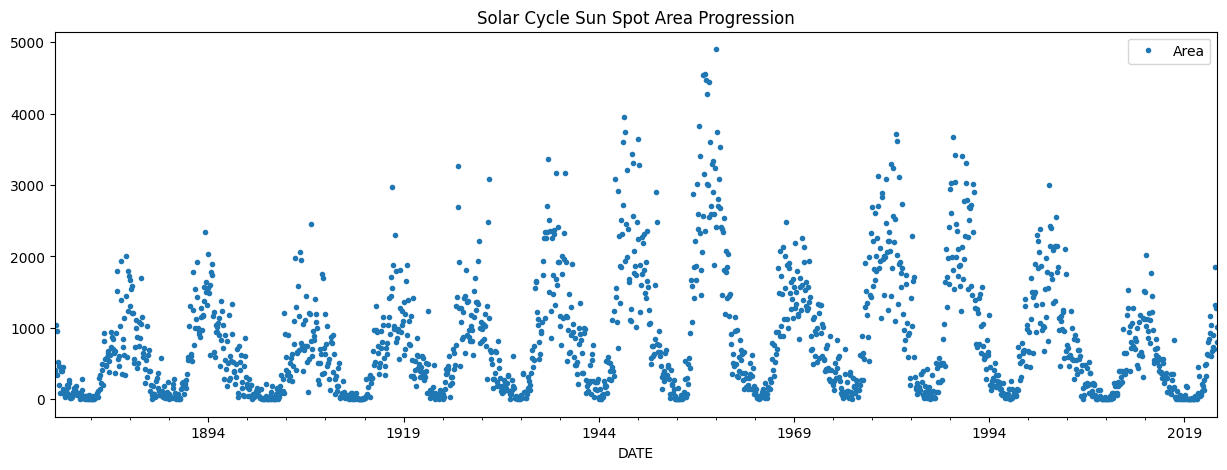

In [344]:
data.plot(style='.',
        figsize=(15, 5),
        title='Solar Cycle Sun Spot Area Progression')
plt.show()

In [345]:
data

,Area
DATE,
1874-05-01,365.1
1874-06-01,415.2
1874-07-01,1033.5
1874-08-01,954.1
1874-09-01,335.3
...,...
2022-12-01,1326.4
2023-01-01,1846.2
2023-02-01,1278.5


In [346]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1788 entries, 1874-05-01 to 2023-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Area    1788 non-null   float64
dtypes: float64(1)
memory usage: 27.9 KB


<Axes: title={'center': 'Peaks'}, xlabel='DATE'>

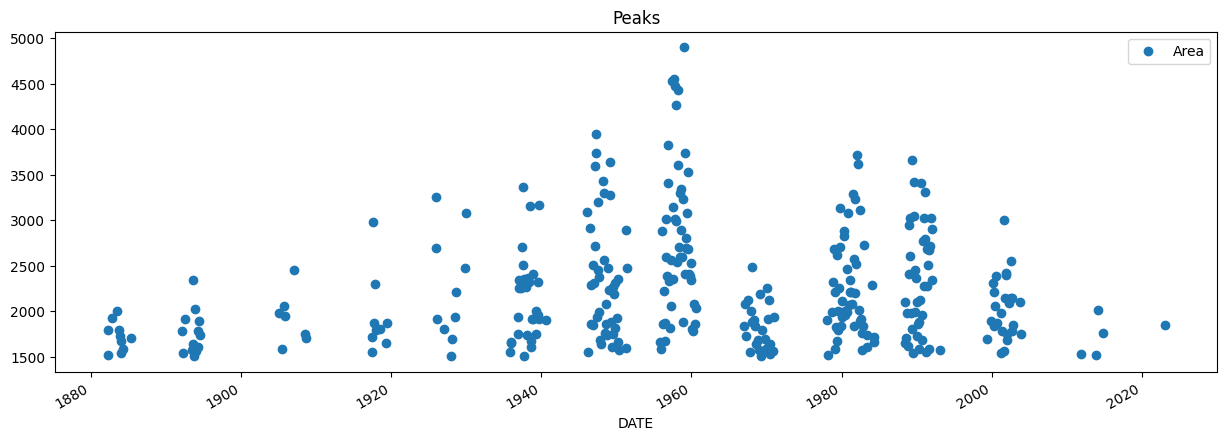

In [347]:
data.query('Area > 1500')\
    .plot(style='o',
          figsize=(15, 5),
          title='Peaks')

In [348]:
data.query('Area == 0')

,Area
DATE,
1878-08-01,0.0
1879-02-01,0.0
1879-03-01,0.0
1889-11-01,0.0
1900-12-01,0.0
1901-04-01,0.0
1901-08-01,0.0
1901-12-01,0.0
1902-04-01,0.0


In [349]:
data.query('Area < 20')

,Area
DATE,
1876-04-01,15.8
1876-06-01,15.2
1877-07-01,4.2
1878-01-01,14.9
1878-02-01,18.1
...,...
2020-02-01,1.4
2020-03-01,1.4
2020-04-01,7.5


In [350]:
a = data.query('Area < 1000')
b = data.query('Area < 20')
c = data.query('Area > 1000')
plt.figure(figsize=(20,5), dpi=1000)
plt.scatter(x=a.index, y=a, marker='.', label='middle values')
plt.scatter(x=c.index, y=c, marker='.', label='higher values')
plt.scatter(x=b.index, y=b, marker='.', edgecolors='black', label='nearly zero values')
plt.legend(['upper values', 'middle values','zero values'])
plt.show()

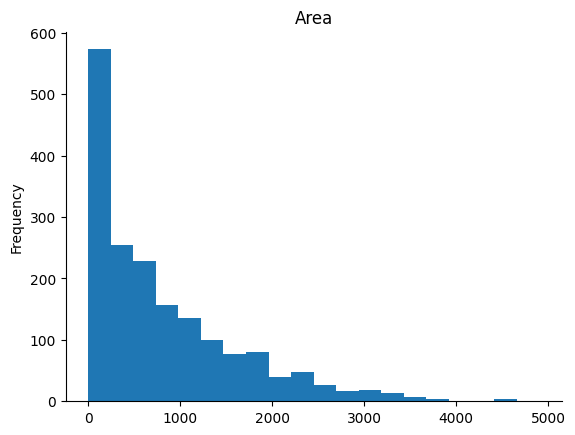

In [351]:
data['Area'].plot(kind='hist', bins=20, title='Area')
plt.gca().spines[['top', 'right',]].set_visible(False)

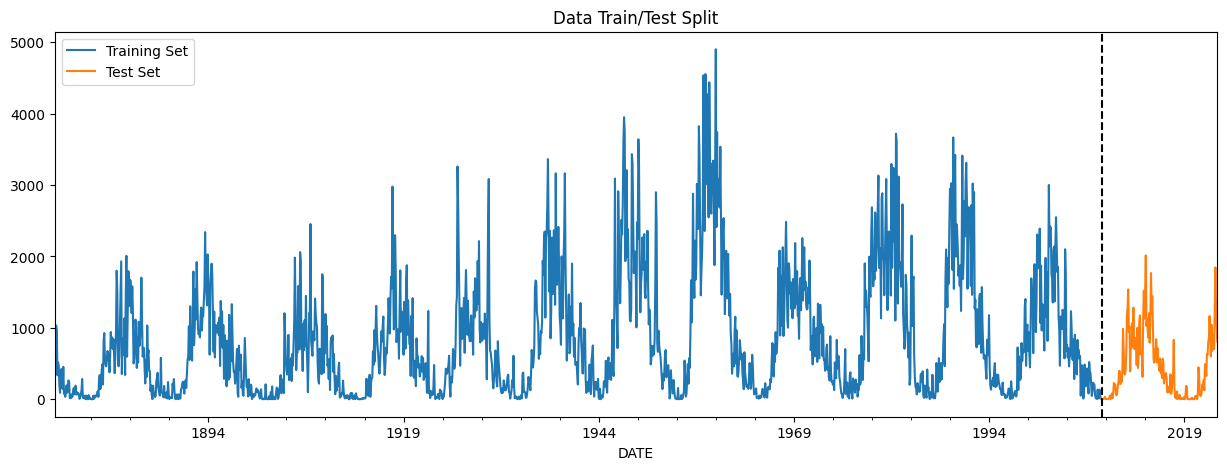

In [352]:
train_scaled = data.loc[data.index < '2008-06-01']
test_scaled = data.loc[data.index >= '2008-06-01']
fig, ax = plt.subplots(figsize=(15, 5))
train_scaled.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_scaled.plot(ax=ax, label='Test Set')
ax.axvline('2008-06-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [353]:
train_scaled

,Area
DATE,
1874-05-01,365.1
1874-06-01,415.2
1874-07-01,1033.5
1874-08-01,954.1
1874-09-01,335.3
...,...
2008-01-01,12.2
2008-02-01,11.1
2008-03-01,133.2


In [354]:
def prepare_data(timeseries_data, n_steps):
    X, y =[],[]
    for i in range(len(timeseries_data)):
        end_ix = i + n_steps
        if end_ix > len(timeseries_data)-1:
            break
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [355]:
n_steps=96
X,y=prepare_data(train_scaled['Area'],n_steps)
val_X,val_y=prepare_data(test_scaled['Area'],n_steps)

In [356]:
X.shape

(1513, 96)

In [357]:
val_X.shape

(83, 96)

In [358]:
X

array([[ 365.1,  415.2, 1033.5, ...,  673.1,  928.9, 1799.1],
       [ 415.2, 1033.5,  954.1, ...,  928.9, 1799.1, 1519.6],
       [1033.5,  954.1,  335.3, ..., 1799.1, 1519.6,  557.8],
       ...,
       [2306.4, 1834. , 2216.1, ...,  135.9,   12.2,   11.1],
       [1834. , 2216.1, 2055.2, ...,   12.2,   11.1,  133.2],
       [2216.1, 2055.2, 2389.5, ...,   11.1,  133.2,   40.6]])

In [359]:
from skopt.space import Real, Categorical, Integer

param_grid = {
    'bootstrap': [True, False],
    'n_estimators': Integer(50, 300),
    'min_weight_fraction_leaf': Real(0.0, 0.5),
    'min_samples_split': Integer(2, 5),
    'min_samples_leaf': Integer(1, 5),
    'max_depth': Integer(2, 50),
    'warm_start': [True, False]
}

In [360]:
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=5,
    max_train_size=1800,
    test_size=180,
)

In [361]:
rfr_model = RandomForestRegressor(criterion='squared_error')

In [362]:
import skopt
from skopt import BayesSearchCV
np.int = np.int64

bay_search = BayesSearchCV(estimator = rfr_model,
                    search_spaces = param_grid,
                    n_iter = 50,
                    cv = ts_cv,
                    scoring = 'neg_mean_squared_error')

bay_search.fit(X, y)

BayesSearchCV(cv=TimeSeriesSplit(gap=5, max_train_size=1800, n_splits=5, test_size=180),
              estimator=RandomForestRegressor(),
              scoring='neg_mean_squared_error',
              search_spaces={'bootstrap': [True, False],
                             'max_depth': Integer(low=2, high=50, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=1, high=5, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=5, prior='uniform', transform='normalize'),
                             'min_weight_fraction_leaf': Real(low=0.0, high=0.5, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=300, prior='uniform', transform='normalize'),
                             'warm_start': [True, False]})

In [363]:
print("val. score: %s" % bay_search.best_score_)
print("test score: %s" % bay_search.score(X, y))
print("best params: %s" % str(bay_search.best_params_))

val. score: -285181.80469720176
test score: -29729.780050793815
best params: OrderedDict([('bootstrap', True), ('max_depth', 36), ('min_samples_leaf', 1), ('min_samples_split', 4), ('min_weight_fraction_leaf', 0.0), ('n_estimators', 237), ('warm_start', False)])


In [364]:
best_params = bay_search.best_params_
best_model = bay_search.best_estimator_

In [365]:
predictions = best_model.predict(val_X).reshape(-1,1)
predictions

array([[ 520.71704826],
       [ 483.67768735],
       [ 439.23597231],
       [ 380.30460167],
       [ 425.11299616],
       [ 372.19809113],
       [ 254.74014952],
       [ 223.74026126],
       [ 201.52623418],
       [ 224.06393359],
       [ 181.44021389],
       [ 319.39862769],
       [ 132.17664842],
       [ 162.9122825 ],
       [ 205.99699308],
       [ 297.50511319],
       [ 386.41041401],
       [ 199.80630668],
       [ 157.46156068],
       [ 101.22420376],
       [ 132.17053764],
       [ 102.59318683],
       [ 124.42072652],
       [  61.34730699],
       [  60.49156436],
       [  43.02726464],
       [  72.55526578],
       [  72.51855389],
       [  33.84541756],
       [  40.00568063],
       [  46.0598987 ],
       [  50.19550185],
       [  37.10925775],
       [  67.18848403],
       [  58.55824392],
       [ 177.11892874],
       [ 171.06593061],
       [  33.00206249],
       [  42.93996986],
       [  40.49162096],
       [  53.79137281],
       [  43.061

In [366]:
RMSE = np.sqrt(MSE(predictions,val_y))
RMSE

177.27746349289902

In [367]:
from sklearn.metrics import r2_score as R2
R2_score=R2(predictions,val_y)
R2_score

0.754334460664644

In [368]:
from sklearn.metrics import mean_absolute_percentage_error
MAPE = mean_absolute_percentage_error(predictions, val_y)
MAPE

0.592783617734366

In [369]:
train_predict = best_model.predict(X).reshape(-1,1)
test_predict = best_model.predict(val_X).reshape(-1,1)

In [370]:
test = np.vstack((train_predict,test_predict))

In [371]:
data1=data[100:]

In [372]:
date=pd.Series(pd.period_range("1/9/1882", freq="M", periods=len(data1)))

In [373]:
test=test.flatten()

In [374]:
data_scaled1=data[100:]

In [375]:
DF = pd.DataFrame()
DF['original'] = data_scaled1
DF = DF.set_index(date)

In [376]:
DF1=pd.DataFrame()
DF1['predicted']=test
DF1 = DF1.set_index(date[:-92])

In [377]:
new = pd.concat([DF, DF1], ignore_index=False, axis=1)
new.head()

,original,predicted
1882-01,1026.9,1396.945518
1882-02,1393.8,908.686710
1882-03,1931.1,684.705234
1882-04,352.9,702.435360
1882-05,849.8,940.361154


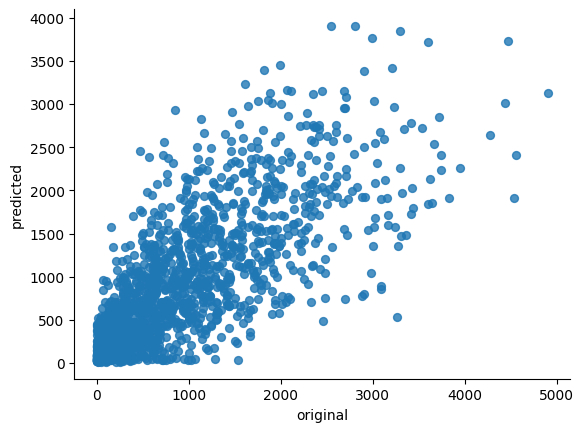

In [378]:
from matplotlib import pyplot as plt
new.plot(kind='scatter', x='original', y='predicted', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

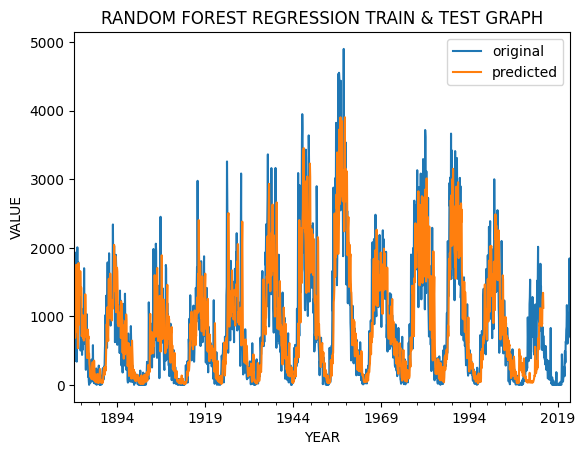

In [379]:
new.plot()
plt.title('RANDOM FOREST REGRESSION TRAIN & TEST GRAPH',color='black')
plt.xlabel('YEAR',color='black')
plt.ylabel('VALUE',color='black')
plt.savefig('RF_train_test.png')

In [380]:
len(test_predict),len(val_y)

(83, 83)

In [381]:
len(data)

1788

In [382]:
data_n=data[:1759]

In [383]:
data_n

,Area
DATE,
1874-05-01,365.1
1874-06-01,415.2
1874-07-01,1033.5
1874-08-01,954.1
1874-09-01,335.3
...,...
2020-07-01,44.5
2020-08-01,36.1
2020-09-01,0.9


In [384]:
import numpy as np

t_df = np.array(data_n).reshape(-1,1)

In [385]:
len(t_df)

1759

In [386]:
fut_inp = t_df[1663:]

In [387]:
fut_inp = fut_inp.reshape(1,-1)

In [388]:
tmp_inp = list(fut_inp)

In [389]:
fut_inp.shape

(1, 96)

In [390]:
tmp_inp = tmp_inp[0].tolist()

In [391]:
predictions

array([[ 520.71704826],
       [ 483.67768735],
       [ 439.23597231],
       [ 380.30460167],
       [ 425.11299616],
       [ 372.19809113],
       [ 254.74014952],
       [ 223.74026126],
       [ 201.52623418],
       [ 224.06393359],
       [ 181.44021389],
       [ 319.39862769],
       [ 132.17664842],
       [ 162.9122825 ],
       [ 205.99699308],
       [ 297.50511319],
       [ 386.41041401],
       [ 199.80630668],
       [ 157.46156068],
       [ 101.22420376],
       [ 132.17053764],
       [ 102.59318683],
       [ 124.42072652],
       [  61.34730699],
       [  60.49156436],
       [  43.02726464],
       [  72.55526578],
       [  72.51855389],
       [  33.84541756],
       [  40.00568063],
       [  46.0598987 ],
       [  50.19550185],
       [  37.10925775],
       [  67.18848403],
       [  58.55824392],
       [ 177.11892874],
       [ 171.06593061],
       [  33.00206249],
       [  42.93996986],
       [  40.49162096],
       [  53.79137281],
       [  43.061

In [392]:
lst_output=[]
n_steps=96
i=0
while(i<133):

    if(len(tmp_inp)>96):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape(( 1,n_steps))
        yhat = best_model.predict(fut_inp).reshape(-1,1)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps))
        yhat = best_model.predict(fut_inp).reshape(-1,1)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

lst_output

[[556.5656735985534],
 [632.6092780426321],
 [687.7813528138525],
 [759.7189201539198],
 [876.8165169780991],
 [919.7294392843439],
 [906.3823253024517],
 [875.2865171455359],
 [931.5235647615393],
 [923.9541281866276],
 [956.7523235519748],
 [931.5137815922938],
 [903.5590722322685],
 [914.2547280825124],
 [1041.5001758087196],
 [1064.803637901011],
 [1119.2270867810103],
 [1283.109318866787],
 [1250.5137768736186],
 [1275.34488312906],
 [1302.6537281494875],
 [1258.5046961020694],
 [1270.1729241176083],
 [1321.649948262006],
 [1405.6791345187864],
 [1440.2945901145267],
 [1524.9860056258794],
 [1567.143094568349],
 [1596.2690780925604],
 [1664.7530490255183],
 [1764.3246885674112],
 [1725.3031643895263],
 [1733.2365620186197],
 [1665.976472272455],
 [1805.2940179827215],
 [1719.7033157524618],
 [1669.127691882661],
 [1705.9334021498894],
 [1854.1415039180226],
 [1669.4923755944017],
 [1631.407680999263],
 [1632.541090348939],
 [1789.956247739602],
 [1716.5863189002748],
 [1708.536191

In [393]:
n_steps=96

X1,y1=prepare_data(t_df,n_steps)

In [394]:
X1.shape

(1663, 96, 1)

In [395]:
X1 = np.array([X1]).reshape(1663, 96)

In [396]:
train_p=best_model.predict(X1).reshape(-1,1)

In [397]:
type(train_p)

numpy.ndarray

In [398]:
test = np.vstack((train_p,lst_output))

In [399]:
test=test.flatten()

In [400]:
data_n = np.array(data_n).reshape(-1,1)

In [401]:
data_scaled2 = data_n[100:]

In [402]:
date=pd.Series(pd.period_range("1/9/1882", freq="M", periods=len(data_scaled1)+133))

In [403]:
DF = pd.DataFrame()
DF['original'] = data_scaled1
DF = DF.set_index(date[:-133])

In [404]:
DF1=pd.DataFrame()
DF1['predicted']=test
DF1 = DF1.set_index(date[:-25])

In [405]:
new = pd.concat([DF, DF1], ignore_index=False, axis=1)
new

,original,predicted
1882-01,1026.9,1396.945518
1882-02,1393.8,908.686710
1882-03,1931.1,684.705234
1882-04,352.9,702.435360
1882-05,849.8,940.361154
...,...,...
2031-04,NaN,37.426419
2031-05,NaN,33.938066
2031-06,NaN,31.166909
2031-07,NaN,28.385674


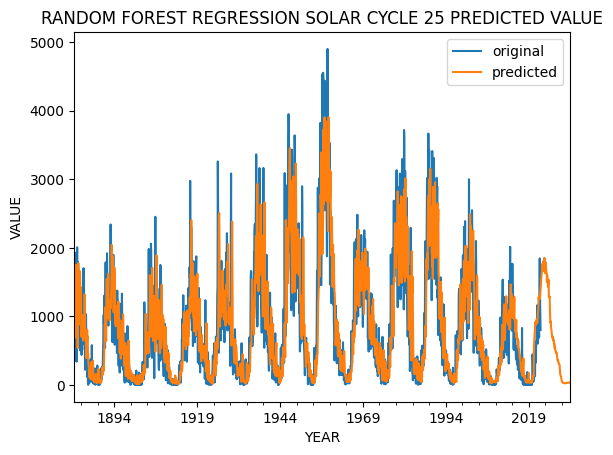

In [406]:
new.plot()
plt.title('RANDOM FOREST REGRESSION SOLAR CYCLE 25 PREDICTED VALUE',color='black')
plt.xlabel('YEAR',color='black')
plt.ylabel('VALUE',color='black')
plt.savefig('RF_predict.png')

In [407]:
print("Largest element is:", max(lst_output))

Largest element is: [1854.1415039180226]


In [408]:
i=max(lst_output)
time=int(np.where(np.array(lst_output) == i)[0])
time

38

In [409]:
new_date = np.datetime64('2020-11') + np.timedelta64(time, 'M')
print('Peak month is : '+str(new_date))


Peak month is : 2024-01


In [410]:
new.query('predicted <= 0')

,original,predicted


In [411]:
output = np.array(lst_output)
output.flatten()

array([ 556.5656736 ,  632.60927804,  687.78135281,  759.71892015,
        876.81651698,  919.72943928,  906.3823253 ,  875.28651715,
        931.52356476,  923.95412819,  956.75232355,  931.51378159,
        903.55907223,  914.25472808, 1041.50017581, 1064.8036379 ,
       1119.22708678, 1283.10931887, 1250.51377687, 1275.34488313,
       1302.65372815, 1258.5046961 , 1270.17292412, 1321.64994826,
       1405.67913452, 1440.29459011, 1524.98600563, 1567.14309457,
       1596.26907809, 1664.75304903, 1764.32468857, 1725.30316439,
       1733.23656202, 1665.97647227, 1805.29401798, 1719.70331575,
       1669.12769188, 1705.93340215, 1854.14150392, 1669.49237559,
       1631.407681  , 1632.54109035, 1789.95624774, 1716.5863189 ,
       1708.53619142, 1646.60100479, 1630.31713794, 1511.38557649,
       1606.1705209 , 1496.39342207, 1517.84312839, 1431.36447391,
       1486.77967886, 1535.20861362, 1303.0579417 , 1283.10351969,
       1277.27586493, 1290.65367503, 1083.67283002,  960.32740

In [412]:
out = output[29:]
out

array([[1664.75304903],
       [1764.32468857],
       [1725.30316439],
       [1733.23656202],
       [1665.97647227],
       [1805.29401798],
       [1719.70331575],
       [1669.12769188],
       [1705.93340215],
       [1854.14150392],
       [1669.49237559],
       [1631.407681  ],
       [1632.54109035],
       [1789.95624774],
       [1716.5863189 ],
       [1708.53619142],
       [1646.60100479],
       [1630.31713794],
       [1511.38557649],
       [1606.1705209 ],
       [1496.39342207],
       [1517.84312839],
       [1431.36447391],
       [1486.77967886],
       [1535.20861362],
       [1303.0579417 ],
       [1283.10351969],
       [1277.27586493],
       [1290.65367503],
       [1083.67283002],
       [ 960.32740925],
       [ 908.17580939],
       [ 926.93271817],
       [ 833.77146825],
       [ 810.78791056],
       [ 770.84129211],
       [ 738.14605937],
       [ 696.3698694 ],
       [ 711.34096494],
       [ 675.06236572],
       [ 672.87070156],
       [ 681.168

In [413]:
train_d = np.array(data['Area'])
train_d.flatten()

array([ 365.1,  415.2, 1033.5, ..., 1278.5, 1013.2,  802. ])

In [414]:
n_data = np.append(train_d, out)

In [415]:
n_data.shape

(1892,)

In [416]:
DATE = pd.Series(pd.period_range("1874-05-01", freq="M", periods=len(data)+104))

In [417]:
new_d = pd.DataFrame()
new_d['Area'] = n_data
new_d = new_d.set_index(DATE)

In [418]:
new_d.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1892 entries, 1874-05 to 2031-12
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Area    1892 non-null   float64
dtypes: float64(1)
memory usage: 29.6 KB


In [419]:
new_d

,Area
1874-05,365.100000
1874-06,415.200000
1874-07,1033.500000
1874-08,954.100000
1874-09,335.300000
...,...
2031-08,37.426419
2031-09,33.938066
2031-10,31.166909
2031-11,28.385674


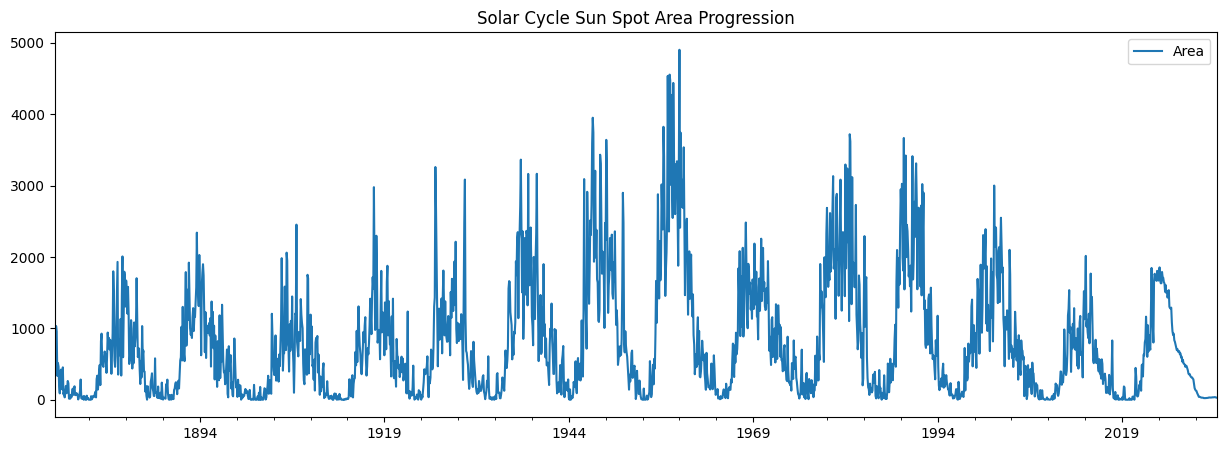

In [420]:
new_d.plot(style='-',
        figsize=(15, 5),
        title='Solar Cycle Sun Spot Area Progression')
plt.show()

In [421]:
new_d.query('Area < 10')

,Area
1877-07,4.2
1878-04,0.4
1878-07,0.4
1878-08,0.0
1878-10,9.6
...,...
2020-02,1.4
2020-03,1.4
2020-04,7.5
2020-05,1.8


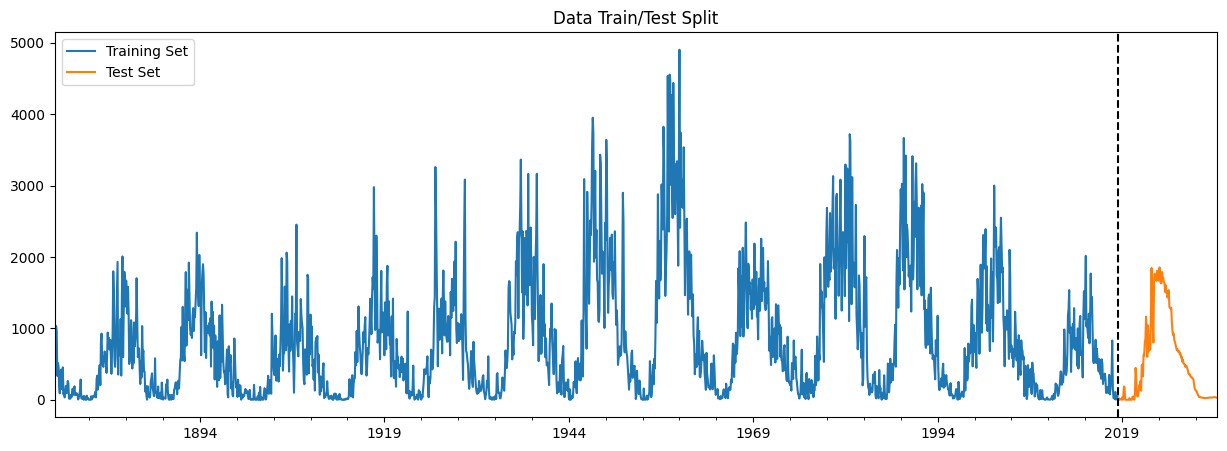

In [422]:
train_d = new_d.loc[new_d.index < '2018-07-01']
test_d = new_d.loc[new_d.index >= '2018-07-01']
fig, ax = plt.subplots(figsize=(15, 5))
train_d.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_d.plot(ax=ax, label='Test Set')
ax.axvline('2018-07-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [423]:
test_d

,Area
2018-07,0.500000
2018-08,21.200000
2018-09,1.900000
2018-10,7.700000
2018-11,11.200000
...,...
2031-08,37.426419
2031-09,33.938066
2031-10,31.166909
2031-11,28.385674


In [424]:
n_steps=96
Xd,yd=prepare_data(train_d['Area'],n_steps)
val_Xd,val_yd=prepare_data(test_d['Area'],n_steps)

In [425]:
Xd.shape

(1634, 96)

In [426]:
val_Xd.shape

(66, 96)

In [427]:
Xd

array([[ 365.1,  415.2, 1033.5, ...,  673.1,  928.9, 1799.1],
       [ 415.2, 1033.5,  954.1, ...,  928.9, 1799.1, 1519.6],
       [1033.5,  954.1,  335.3, ..., 1799.1, 1519.6,  557.8],
       ...,
       [  85.4,   54.9,   85.9, ...,    8.6,  109.5,    2.7],
       [  54.9,   85.9,  182.5, ...,  109.5,    2.7,   28. ],
       [  85.9,  182.5,  234.4, ...,    2.7,   28. ,   33.9]])

In [428]:
ts_cv2 = TimeSeriesSplit(
    n_splits=5,
    gap=5,
    max_train_size=2000,
    test_size=163,
)

In [429]:
import skopt
from skopt import BayesSearchCV
np.int = np.int64

bay_search = BayesSearchCV(estimator = rfr_model,
                    search_spaces = param_grid,
                    n_iter = 50,
                    cv = ts_cv2,
                    scoring = 'neg_mean_squared_error')

bay_search.fit(Xd, yd)

BayesSearchCV(cv=TimeSeriesSplit(gap=5, max_train_size=2000, n_splits=5, test_size=163),
              estimator=RandomForestRegressor(),
              scoring='neg_mean_squared_error',
              search_spaces={'bootstrap': [True, False],
                             'max_depth': Integer(low=2, high=50, prior='uniform', transform='normalize'),
                             'min_samples_leaf': Integer(low=1, high=5, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=5, prior='uniform', transform='normalize'),
                             'min_weight_fraction_leaf': Real(low=0.0, high=0.5, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=300, prior='uniform', transform='normalize'),
                             'warm_start': [True, False]})

In [430]:
print("val. score: %s" % bay_search.best_score_)
print("test score: %s" % bay_search.score(Xd, yd))
print("best params: %s" % str(bay_search.best_params_))

val. score: -212209.20460429048
test score: -55126.97743329237
best params: OrderedDict([('bootstrap', True), ('max_depth', 42), ('min_samples_leaf', 5), ('min_samples_split', 2), ('min_weight_fraction_leaf', 0.0), ('n_estimators', 300), ('warm_start', True)])


In [431]:
best_params = bay_search.best_params_
best_model = bay_search.best_estimator_

In [432]:
predictions2 = best_model.predict(val_Xd).reshape(-1,1)
predictions2

array([[777.55460065],
       [745.07446692],
       [758.11833114],
       [756.03402705],
       [716.73473054],
       [679.57732814],
       [621.92043227],
       [610.05000648],
       [534.91341946],
       [534.95871997],
       [498.04933397],
       [453.014841  ],
       [437.8182903 ],
       [457.77636168],
       [455.94068093],
       [463.85631537],
       [461.59585223],
       [434.71747191],
       [394.81978962],
       [381.42687951],
       [383.87935753],
       [370.815207  ],
       [333.8456343 ],
       [342.40233341],
       [339.17173686],
       [332.08514205],
       [324.46395421],
       [253.26120441],
       [205.75879506],
       [156.51212099],
       [150.92844267],
       [146.09901322],
       [116.61896536],
       [108.74827856],
       [ 78.70142703],
       [ 59.18334006],
       [ 53.06140779],
       [ 50.15694985],
       [ 46.03773245],
       [ 37.71116864],
       [ 36.56884455],
       [ 33.3057046 ],
       [ 31.64999426],
       [ 27

In [433]:
RMSE = np.sqrt(MSE(predictions2,val_yd))
RMSE

28.331495077693596

In [434]:
from sklearn.metrics import r2_score as R2
R2_score=R2(predictions2,val_yd)
R2_score

0.9864523820783698

In [435]:
from sklearn.metrics import mean_absolute_percentage_error
MAPE = mean_absolute_percentage_error(predictions2, val_yd)
MAPE

0.15926068702953944

In [436]:
train_pred = best_model.predict(Xd).reshape(-1,1)
test_pred = best_model.predict(val_Xd).reshape(-1,1)

In [437]:
test2 = np.vstack((train_pred,test_pred))

In [438]:
test2=test2.flatten()

In [439]:
test2.shape

(1700,)

In [440]:
new_d1 = new_d[96:]
new_d1.shape

(1796, 1)

In [441]:
date=pd.Series(pd.period_range("1882-05-01", freq="M", periods=len(new_d1)))

In [442]:
DF = pd.DataFrame()
DF['original'] = new_d1
DF = DF.set_index(date)

In [443]:
DF1=pd.DataFrame()
DF1['predicted']=test2
DF1 = DF1.set_index(date[:-96])

In [444]:
new2 = pd.concat([DF, DF1], ignore_index=False, axis=1)
new2.head()

,original,predicted
1882-05,1519.6,1430.342348
1882-06,557.8,924.137471
1882-07,461.5,736.419023
1882-08,607.6,666.670064
1882-09,1026.9,914.237309


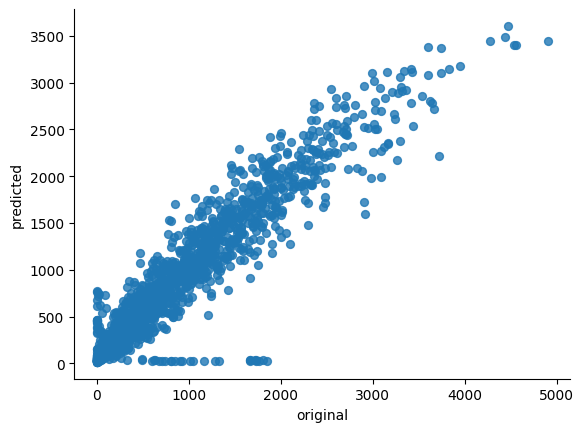

In [445]:
from matplotlib import pyplot as plt
new2.plot(kind='scatter', x='original', y='predicted', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

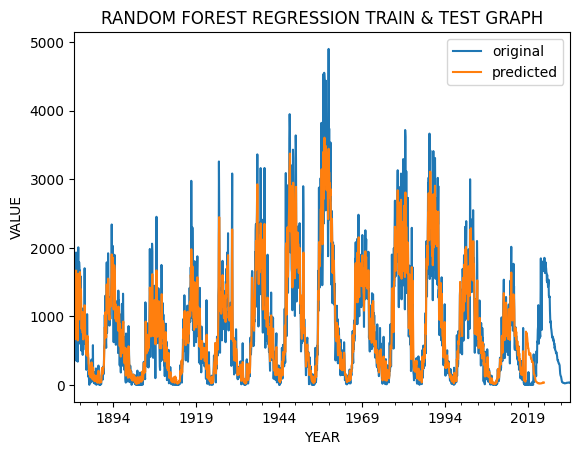

In [446]:
new2.plot()
plt.title('RANDOM FOREST REGRESSION TRAIN & TEST GRAPH',color='black')
plt.xlabel('YEAR',color='black')
plt.ylabel('VALUE',color='black')
plt.savefig('RF_train_test.png')

In [447]:
len(test_pred),len(val_yd)

(66, 66)

In [448]:
len(new_d1)

1796

In [449]:
new_d.query('Area < 30')

,Area
1876-04,15.800000
1876-06,15.200000
1877-07,4.200000
1877-12,23.300000
1878-01,14.900000
...,...
2030-06,24.610872
2030-07,24.941388
2030-08,26.353711
2030-09,27.216237


In [450]:
data_n=new_d[:1876]

In [451]:
data_n

,Area
1874-05,365.100000
1874-06,415.200000
1874-07,1033.500000
1874-08,954.100000
1874-09,335.300000
...,...
2030-04,23.132281
2030-05,24.511381
2030-06,24.610872
2030-07,24.941388


In [452]:
import numpy as np

t_df = np.array(data_n).reshape(-1,1)

In [453]:
len(t_df)

1876

In [454]:
fut_inp = t_df[1780:]

In [455]:
fut_inp = fut_inp.reshape(1,-1)

In [456]:
tmp_inp = list(fut_inp)

In [457]:
fut_inp.shape

(1, 96)

In [458]:
tmp_inp = tmp_inp[0].tolist()

In [459]:
predictions2

array([[777.55460065],
       [745.07446692],
       [758.11833114],
       [756.03402705],
       [716.73473054],
       [679.57732814],
       [621.92043227],
       [610.05000648],
       [534.91341946],
       [534.95871997],
       [498.04933397],
       [453.014841  ],
       [437.8182903 ],
       [457.77636168],
       [455.94068093],
       [463.85631537],
       [461.59585223],
       [434.71747191],
       [394.81978962],
       [381.42687951],
       [383.87935753],
       [370.815207  ],
       [333.8456343 ],
       [342.40233341],
       [339.17173686],
       [332.08514205],
       [324.46395421],
       [253.26120441],
       [205.75879506],
       [156.51212099],
       [150.92844267],
       [146.09901322],
       [116.61896536],
       [108.74827856],
       [ 78.70142703],
       [ 59.18334006],
       [ 53.06140779],
       [ 50.15694985],
       [ 46.03773245],
       [ 37.71116864],
       [ 36.56884455],
       [ 33.3057046 ],
       [ 31.64999426],
       [ 27

In [460]:
lst_output=[]
n_steps=96
i=0
while(i<133):

    if(len(tmp_inp)>96):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape(( 1,n_steps))
        yhat = best_model.predict(fut_inp).reshape(-1,1)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps))
        yhat = best_model.predict(fut_inp).reshape(-1,1)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

lst_output

[[22.658025658245545],
 [21.849058680923182],
 [21.373303080369062],
 [17.27021827620264],
 [18.25266885756573],
 [16.937323252163516],
 [16.74964925483874],
 [16.36285013970808],
 [15.794189548773963],
 [14.997760144028376],
 [14.385498924692152],
 [16.640784317110487],
 [18.975134789867578],
 [17.626726377854737],
 [21.418404233958345],
 [24.04332602763308],
 [31.29109771659512],
 [35.10011744893251],
 [45.52037398691492],
 [55.685243045361894],
 [65.30062144114912],
 [92.80864774926367],
 [167.99751744546313],
 [208.80507933931523],
 [225.62469115207395],
 [255.43967145800679],
 [291.8755668452635],
 [335.1789648922442],
 [418.44922416491613],
 [447.77110435112417],
 [634.6812847474724],
 [708.7068798060543],
 [814.1023011516784],
 [846.6799236190532],
 [840.9254263694073],
 [837.5422591671653],
 [834.6336526051272],
 [825.1399638672582],
 [840.5196523982694],
 [860.4745433385658],
 [858.3636108276128],
 [864.1634307882127],
 [889.6834979421909],
 [898.1797684447819],
 [888.12301381

In [461]:
n_steps=96

X1,y1=prepare_data(t_df,n_steps)

In [462]:
X1.shape

(1780, 96, 1)

In [463]:
X1 = np.array([X1]).reshape(1780, 96)

In [464]:
train_p=best_model.predict(X1).reshape(-1,1)

In [465]:
type(train_p)

numpy.ndarray

In [466]:
test_2 = np.vstack((train_p,lst_output))

In [467]:
test_2=test_2.flatten()

In [468]:
data_n = np.array(data_n).reshape(-1,1)

In [469]:
data_s2 = data_n[96:]

In [470]:
date=pd.Series(pd.period_range("1882-05-01", freq="M", periods=len(new_d1)+133))

In [471]:
DF = pd.DataFrame()
DF['original'] = new_d1
DF = DF.set_index(date[:-133])

In [472]:
DF1=pd.DataFrame()
DF1['predicted']=test_2
DF1 = DF1.set_index(date[:-16])

In [473]:
new = pd.concat([DF, DF1], ignore_index=False, axis=1)
new

,original,predicted
1882-05,1519.6,1430.342348
1882-06,557.8,924.137471
1882-07,461.5,736.419023
1882-08,607.6,666.670064
1882-09,1026.9,914.237309
...,...,...
2041-05,NaN,411.344900
2041-06,NaN,419.095044
2041-07,NaN,423.268893
2041-08,NaN,431.999461


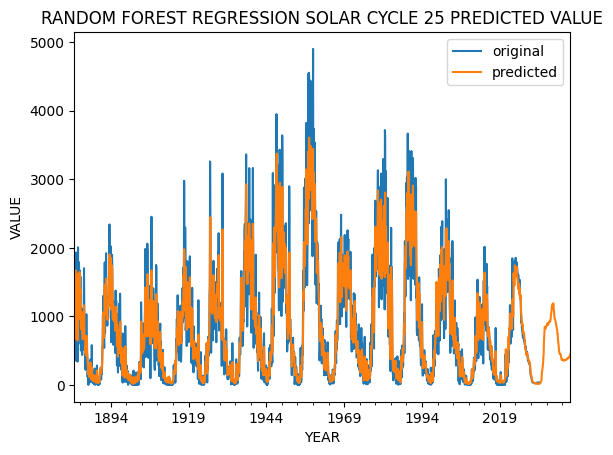

In [474]:
new.plot()
plt.title('RANDOM FOREST REGRESSION SOLAR CYCLE 26 PREDICTED VALUE',color='black')
plt.xlabel('YEAR',color='black')
plt.ylabel('VALUE',color='black')
plt.savefig('RF_predict.png')

In [475]:
print("Largest element is:", max(lst_output))

Largest element is: [1187.0654576383538]


In [476]:
i=max(lst_output)
time=int(np.where(np.array(lst_output) == i)[0])
time

66

In [477]:
new_date = np.datetime64('2030-08') + np.timedelta64(time, 'M')
print('Peak month is : '+str(new_date))


Peak month is : 2036-02


In [478]:
new.query('predicted <= 0')

,original,predicted
